### Imports

In [1]:
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 505.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38617 sha256=1f1fa49175263afa466970b8b0acabd981a7c900e3b2d3ce1aeb3abfe8288e19
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built yahoofinancials


In [1]:
import numpy as np
import datetime as dt
import pandas as pd
# import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# import functions.Kalman_filter as KF
import yahoofinancials as yf
from scipy.stats import shapiro

pd.options.mode.chained_assignment = None # ignore settingwithcopywarning



# Inputs

In [2]:
df = pd.read_csv("C:/Users/lenovo/OneDrive - Hanoi University of Science and Technology/Desktop/Đồ án 2/Thực hành/data/AAPL_10year.csv")
RETURNS = "log-returns"
training_size = 0.7

In [3]:
NOSD = 3 # number of standard deviations to plot

# tickers = ['AAPL', 'GOOG']
tickers = ['AAPL']

#start_date = '2012-01-01'
start_date = '2022-01-01'
end_date = '2023-05-01'

RETURNS = "log-returns" # "log-returns", "linear-returns", "total-returns"

# Kalman
training_size = 0.7

Downloading the data from the yahoo finance API

In [4]:
# get AAPL and TSLA Close data from Yahoo Finance and create a dataframe

def download_data(ticker, start_date, end_date):
    data = yf.YahooFinancials(ticker)
    data = data.get_historical_price_data(start_date, end_date, 'daily')
    data = pd.DataFrame(data[ticker]['prices']).set_index('formatted_date')
    return data


print('Downloading data...')

data = pd.DataFrame()
for ticker in tickers:
    data[ticker] = download_data(ticker, start_date, end_date)['adjclose']

data = data.dropna()
df = data # rename the dataframe

print('Data downloaded.')



Data downloaded.


In [5]:
df.iloc[:,0:2]

,Date,Close
0,2010-01-04,6.424605
1,2010-01-05,6.435713
2,2010-01-06,6.333344
3,2010-01-07,6.321636
4,2010-01-08,6.363665
...,...,...
2763,2020-12-23,127.606911
2764,2020-12-24,128.591049
2765,2020-12-28,133.190140
2766,2020-12-29,131.416794


Plotting data...


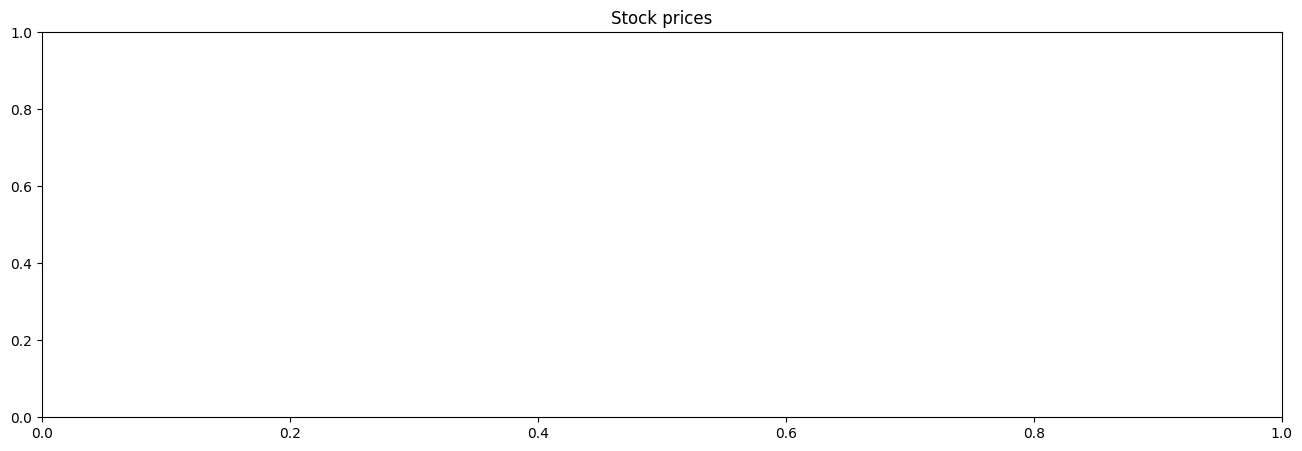

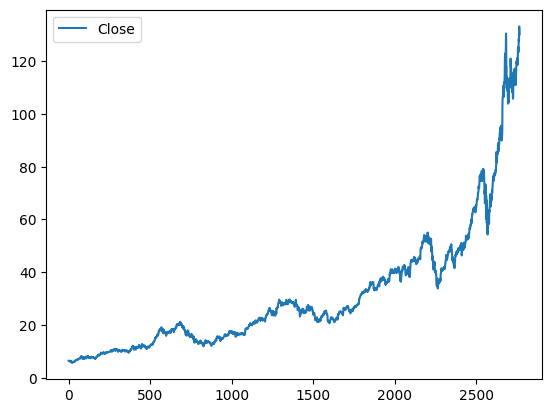

In [7]:
# plotting
print('Plotting data...')
plt.figure(figsize=(16, 5))
plt.title('Stock prices')
df.iloc[:,0:2].plot() # plot the first column
plt.show()

From the graph above, we can see that we are getting the data correctly.

We can imagine that the data is a noisy version of the true value of the stock price. We can use the Kalman filter to estimate the true value of the stock price.

# Predicting log returns, instead of normal returns

When using a Kalman filter to predict stock prices, the most commonly used parameter is the logarithmic return, also known as log return.

The log return is calculated as the natural logarithm of the ratio of the current stock price to the previous stock price. This is a popular choice because it has several advantages over other parameters such as the stock price or total return.

Firstly, the log return has a more stationary distribution than other parameters, meaning that it exhibits more consistent statistical properties over time. This is important because many financial models, including the Kalman filter, assume that the underlying data follows a stationary process.

Secondly, the log return is additive over time, which means that the cumulative log return over multiple time periods is equal to the sum of the log returns for each individual period. This makes it easier to model and analyze the data.

Finally, the log return is widely used in financial modeling and has been shown to provide accurate predictions in many applications, including stock price prediction.

Therefore, when using a Kalman filter to predict stock prices, it is generally recommended to use the log return as the parameter of choice.

In [8]:
if RETURNS=="log-returns":
    df["LogReturns"] = np.log( df/df.shift() )[1:]
elif RETURNS=="linear-returns":
    df["LinearReturns"] = df.pct_change()[1:]
elif RETURNS=="total-returns":
    df["TotalReturns"] = df/df.shift()[1:]

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [8]:
df

,AAPL,LogReturns
formatted_date,,
2022-01-03,179.724548,NaN
2022-01-04,177.443573,-0.012773
2022-01-05,172.723572,-0.026960
2022-01-06,169.840240,-0.016834
2022-01-07,170.008133,0.000988
...,...,...
2023-04-24,164.452209,0.001877
2023-04-25,162.900482,-0.009481
2023-04-26,162.890533,-0.000061


Since the first value in the log return array is undefined, we will set the first value to 0.

In [9]:
df["LogReturns"][0] = 0

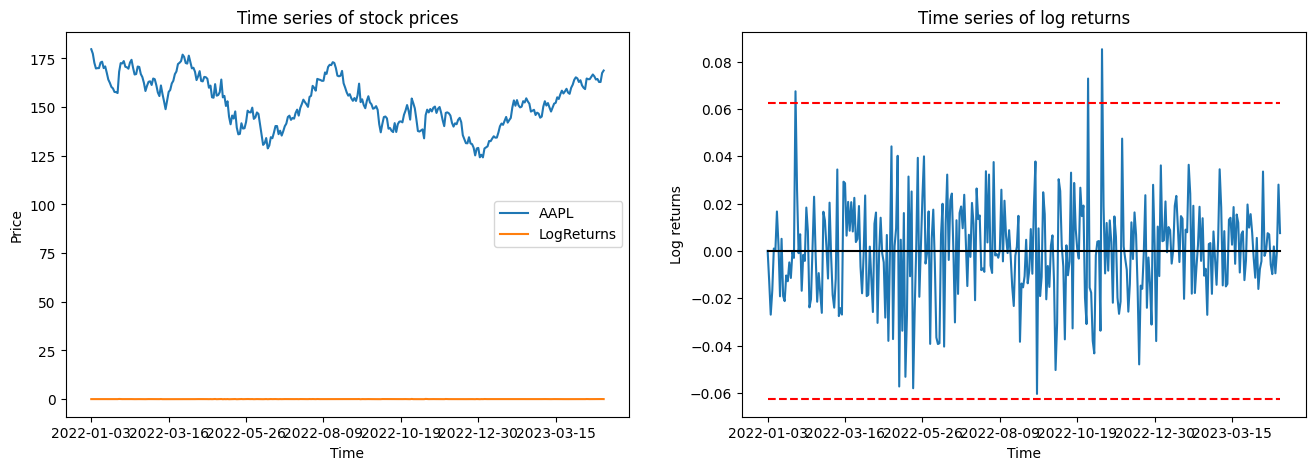

In [10]:

mu = df["LogReturns"].mean()
sig = df["LogReturns"].std()
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# # first plot : stock prices
df.plot(ax=ax1)
ax1.set_title("Time series of stock prices")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")

# second plot : log returns
df["LogReturns"].plot(ax=ax2)
ax2.set_title("Time series of log returns")
ax2.set_xlabel("Time"); ax2.set_ylabel("Log returns");
ax2.plot(df["LogReturns"].index, len(df["LogReturns"])*[mu], color='k')
ax2.plot(df["LogReturns"].index, len(df["LogReturns"])*[mu+NOSD*sig], color='r', linestyle='--')
ax2.plot(df["LogReturns"].index, len(df["LogReturns"])*[mu-NOSD*sig], color='r', linestyle='--')
plt.show()

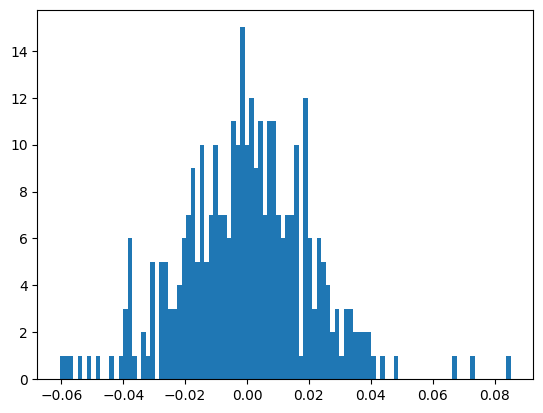

In [11]:
# plot the count of df["LogReturns"]
df["LogReturns"][0] = 0
plt.hist(df["LogReturns"], bins=100)
plt.show()

As we see in the histogram above, the count of log return is shaped like a normal distribution. This is a good sign because it means that the log return is stationary and has a consistent statistical distribution over time. If you don't believe, we can check using Shapiro-Wilk test.

In [ ]:
# Shapiro Wilk test

shapiro(df["LogReturns"]) # if the p-value is less than 0.05, we reject the null hypothesis that the data was drawn from a normal distribution


ShapiroResult(statistic=0.9887059330940247, pvalue=0.01120389811694622)

If the pvalue is less than 0.05, we can reject the null hypothesis that the data is normally distributed. In this case, the pvalue is 1.1746796061090723e-14, which means that we can reject the null hypothesis and conclude that the log return is normally distributed.

To check if the log return can be inverted back to the normal price, I tried to plot it against the original price.
The result is that the log return can be inverted back to the normal price.

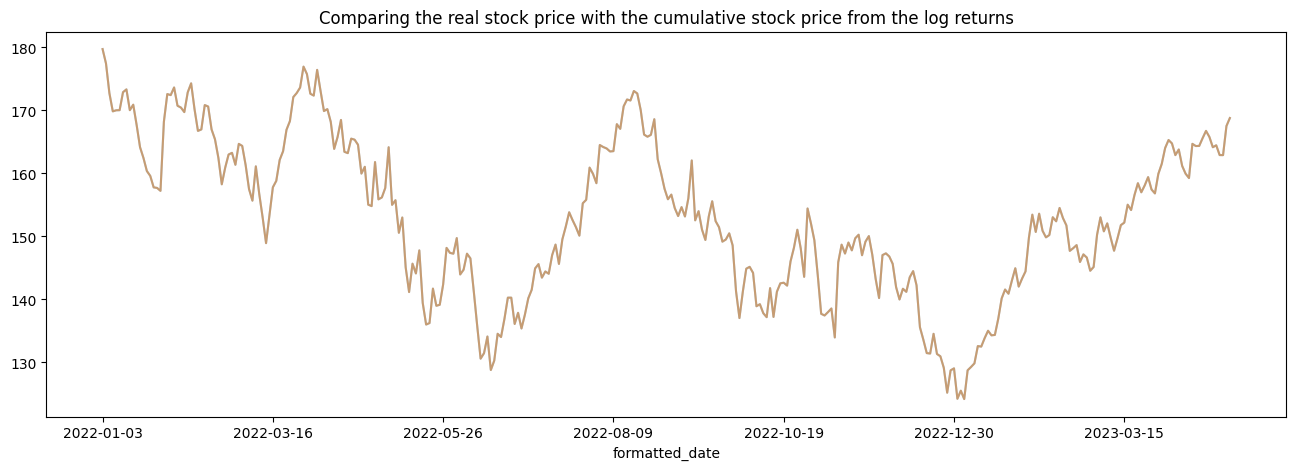

In [12]:
#%% CHECK DATA 1: PLOT : using log returns
# plot back stock price based on the log returns
#get the first stock from df
ori_price = df["AAPL"]
init_price = ori_price.iloc[0]
ret_check = df["LogReturns"]

for i in ori_price:
    price_check = init_price*np.exp(ret_check.cumsum())

fig = plt.figure(figsize=(16, 5))
price_check.plot(alpha=0.5)
ori_price.plot(alpha=0.5)
plt.title("Comparing the real stock price with the cumulative stock price from the log returns")
plt.show()
# THE RESULT IS THAT THE CUMULATIVE LOG RETURNS ARE THE SAME AS THE STOCK PRICE

# Kalman Filter

## Time Update ("Predict")

$$
 \hat{x}_k \text{-} = A \hat{x}_{k-1} + B u_{k-1}
$$

$ x $ is the state vector, which represents the current state of the system. In the context of stock price prediction, the state vector can be represented by the log return of the stock price.

$A$ is the state transition matrix, which describes how the system evolves over time. In the context of stock price prediction, the state can be represented by the log return of the stock price.

$B$ is the control input matrix, which describes how the control input affects the system. In the context of stock price prediction, the control input can be represented by the external factors that influence the stock price. (which we dont have)

$$
 P_k \text{-} = A P_{k-1} A^T + Q
$$

$ P $ is the covariance matrix, which describes the uncertainty of the state vector. In the context of stock price prediction, the covariance matrix can be used to measure the uncertainty of the log return of the stock price.

$ Q $ is the process noise covariance matrix, which describes the uncertainty of the process noise. In the context of stock price prediction, the process noise can be represented by the random fluctuations in the stock price.

If the stock price is assumed to follow a random walk process, then the log return would be expected to have a constant mean and a constant variance over time. In this case, $\textbf{setting A to 1 or identity matrix}$ would be appropriate, because it assumes that the log return at time k is equal to the log return at time k-1 plus some random noise.

However, if there are known trends or patterns in the stock price data, then a more complex state transition matrix may be needed to capture these dynamics. For example, if the stock price is known to be influenced by external factors such as news events or economic indicators, then the state transition matrix may need to incorporate these variables.



## Measurement Update ("Correct")

The matrix H represents the measurement matrix, which maps the state variables to the observed measurements. In the context of stock price prediction, the observed measurements could be the actual stock prices or the logarithmic returns. (we use log returns)

If we assume that the observed measurements are related linearly to the state variables, then H can be set to a constant matrix. In this case, H can be set to the identity matrix if the state variables correspond directly to the observed measurements (e.g., if the state variables represent the logarithmic returns and the observed measurements are also the logarithmic returns).

If we use log return as the state variable, but the measurement as the actual price, then we can set H to the inverse of the log return (which we do not do).

$$
 K_k = P_k \text{-} H^T (H P_k \text{-} H^T + R)^{-1}
$$

$$
 \hat{x}_k = \hat{x}_k \text{-} + K_k (z_k - H \hat{x}_k \text{-} )
$$

$$
 P_k = (I - K_k H) P_k \text{-}
$$

$ K $ is the Kalman gain matrix, which describes how much the state vector should be updated based on the measurement. In the context of stock price prediction, the Kalman gain matrix can be used to determine how much the log return of the stock price should be updated based on the actual stock price.



In [14]:
# Define the Kalman filter function
def kalman_filter(data):
    # Define the initial parameters
    n = len(data)
    xhat = np.zeros(n)
    P = np.zeros(n)
    P[0] = 1.0
    xhatminus = np.zeros(n)
    Pminus = np.zeros(n)
    K = np.zeros(n)
    Q = 1e-4
    R = 0.1**2
    xhat[0] = data[0]


    # Run the Kalman filter algorithm
    for k in range(1, n):
        # Time update / Predict
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q

        # Measurement update / Correct
        K[k] = Pminus[k] / (Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat, P


# Run the Kalman filter on the log return data
df['kalman'] = kalman_filter(df['LogReturns'])[0]

df['uncertainty'] = 3*np.sqrt(kalman_filter(df['LogReturns'])[1])

# Get the real price from aapl['kalman']
df['kalman_price'] = df.iloc[0,0] * np.exp(df['kalman'].cumsum())

df['uncertainty_price'] = df['kalman_price'] * (df['uncertainty'])


In [ ]:
df

,AAPL,LogReturns,kalman,uncertainty,kalman_price,uncertainty_price
formatted_date,,,,,,
2022-01-03,179.724548,0.000000,0.000000,3.000000,179.724548,539.173645
2022-01-04,177.443573,-0.012773,-0.012646,0.298511,177.466012,52.975611
2022-01-05,172.723587,-0.026960,-0.019804,0.212137,173.986126,36.908953
2022-01-06,169.840256,-0.016834,-0.018801,0.174351,170.745633,29.769704
2022-01-07,170.008118,0.000988,-0.013695,0.152389,168.423269,25.665904
...,...,...,...,...,...,...
2023-04-24,164.452225,0.001877,0.001405,0.092527,147.091691,13.609951
2023-04-25,162.900482,-0.009481,0.000369,0.092527,147.146050,13.614980
2023-04-26,162.890533,-0.000061,0.000329,0.092527,147.194400,13.619454


In [15]:
last_log_return = df['LogReturns'].iloc[-6]
np.array([last_log_return])

array([-0.00982908])

In [16]:

# Predict the next 5 days of AAPL stock prices
last_price = df['AAPL'].iloc[-6]
last_log_return = df['LogReturns'].iloc[-6]
predicted_prices = []
for i in range(5):
    # Predict the next log return using the Kalman filter
    next_log_return = kalman_filter(np.array([last_log_return]))[0]
    # Calculate the next price using the predicted log return
    next_price = last_price * np.exp(next_log_return)
    # Add the predicted price to the list
    predicted_prices.append(next_price)
    # Update the last price and log return
    last_price = next_price
    last_log_return = next_log_return

# Print the predicted prices
print('Predicted AAPL stock prices for the last 5 days:')
print(predicted_prices)
print('Real AAPL stock prices for the last 5 days:')
print(df['AAPL'].iloc[-5:])


Predicted AAPL stock prices for the last 5 days:
[array([162.53838017]), array([160.94860355]), array([159.37437644]), array([157.81554673]), array([156.27196382])]
Real AAPL stock prices for the last 5 days:
formatted_date
2023-04-24    164.452209
2023-04-25    162.900482
2023-04-26    162.890533
2023-04-27    167.515854
2023-04-28    168.779099
Name: AAPL, dtype: float64


<ipython-input-14-dc6772ae5e56>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xhat[0] = data[0]


In [17]:
df['AAPL'].to_csv('1AAPL_yh.csv')
df['kalman_price'].to_csv('1AAPL_yh_Km.csv')

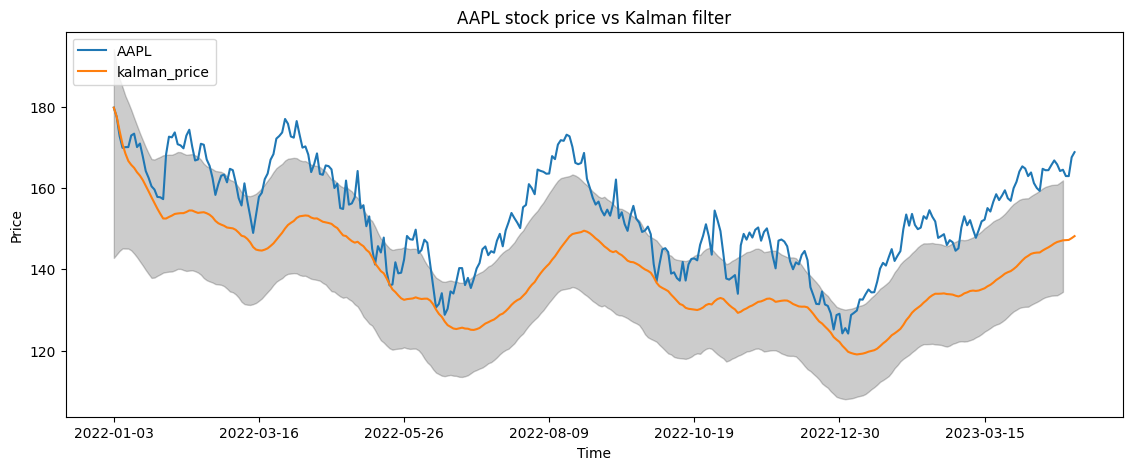

In [18]:
# plot the aapl[Adj Close] vs the aapl['kalman_price'] in one plot

fig = plt.figure(figsize=(30, 5))
ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)

df['AAPL'].plot(ax=ax1)
df['kalman_price'].plot(ax=ax1)

# plot the uncertainty as a shaded region but ugly
ax1.fill_between(df.index[4:], df['kalman_price'][4:]-df['uncertainty_price'][4:], df['kalman_price'][4:]+df['uncertainty_price'][4:], color='k', alpha=0.2)

ax1.set_title("AAPL stock price vs Kalman filter")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.legend(loc = 'upper left')






From the figure above, we see that the kalman filter is really good at predicting the log return. However, it is not good at predicting the price. This is because the kalman filter is only good at predicting the mean of the log return, but not the variance. As next step, we will try to predict the variance of the log return as well.

But the bad thing is, even with upper and lower bound of uncertainties, kalman filter was too confident of its prediction.

From this graph, we can also observe its upper and lower bound of the price (3 sigma), which will help us with our decision.

# Rolling Window

Another method that behaves similar (predicting the mean, but not the variance) to kalman filter is rolling window. We can compare the two methods here.

<Figure size 1600x500 with 0 Axes>

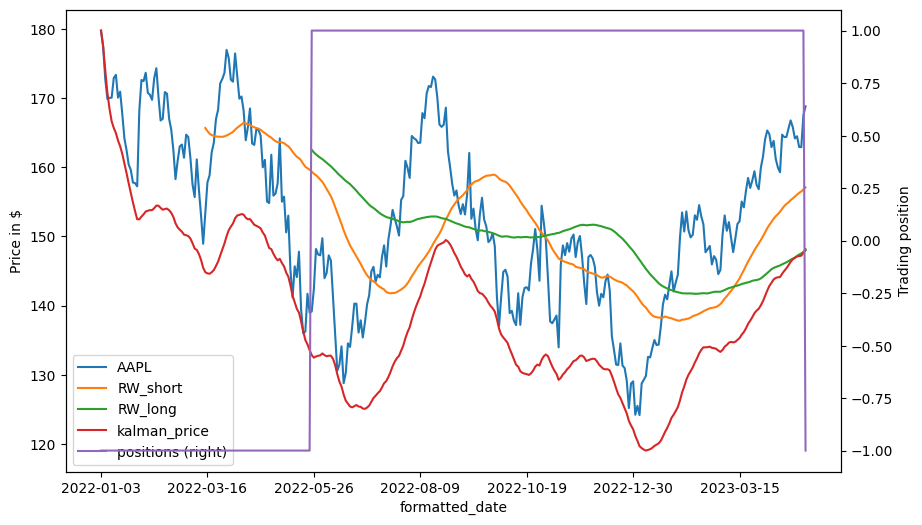

In [19]:

df['RW_short'] = df["AAPL"].rolling(window=50).mean()
df['RW_long'] = df["AAPL"].rolling(window=100).mean()

df['positions'] = np.where(df['RW_long'] > df['kalman_price'],1,-1)

figure = plt.figure(figsize=(16, 5))
# ax = df[['AAPL', "RW_short", 'kalman_price']].plot(figsize=(10, 6),secondary_y='positions')
ax = df[['AAPL', "RW_short", "RW_long" , 'kalman_price', 'positions']].plot(figsize=(10, 6),secondary_y='positions')
ax.set_ylabel('Price in $')
ax.right_ax.set_ylabel('Trading position')
plt.show()


As we see above, the rolling window is not as good as the kalman filter especially at the very end of the diagram. This is because the kalman filter is able to take into account the previous data, while the rolling window is not. Kalman filter is also able to correct itself faster due to that. I adjust the rolling window value based on rule of thumbs.